# Part1. Train mnist data

In [1]:
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import mnist_inference
import mnist_evaluate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 5000
MOVING_AVERAGE_DECAY = 0.99

MODEL_SAVE_PATH = './model_save_dir/model.ckpt'

In [3]:
def train(mnist):
    x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
    y = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
    
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    y_ = mnist_inference.inference(x, regularizer)
    
    global_step = tf.Variable(0, trainable=False)
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    
    cross_entropy = tf.losses.softmax_cross_entropy(logits=y_, onehot_labels=y)
    loss = tf.losses.get_total_loss(add_regularization_losses=True)
    
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        mnist.train.num_examples / BATCH_SIZE,
        LEARNING_RATE_DECAY)
    train_step = tf.train.GradientDescentOptimizer(learning_rate)\
                   .minimize(loss, global_step=global_step)
    train_op = tf.group(train_step, variables_averages_op)
    
    saver = tf.train.Saver()
    
    plot_loss = {'step':[], 'loss':[]}
    plot_accuracy = {'step':[], 'accuracy':[]}
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x:xs, y:ys})
            plot_loss['step'].append(step)
            plot_loss['loss'].append(loss_value)
            if step % 250 == 0:
                saver.save(sess, MODEL_SAVE_PATH, global_step=step)
                accuracy_value = mnist_evaluate.evaluate(mnist)
                plot_accuracy['step'].append(step)
                plot_accuracy['accuracy'].append(accuracy_value)
                print('step %d: loss on training batch is %g, validation accuracy is %g.' 
                      % (step, loss_value, accuracy_value))
                
    return plot_loss, plot_accuracy

In [4]:
tf.reset_default_graph()
mnist = input_data.read_data_sets('./mnist_data/', one_hot=True)
plot_loss, plot_accuracy = train(mnist)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./model_save_dir/model.ckpt-250
step 250: loss on training batch is 0.327681, validation accuracy is 0.9604.
INFO:tensorflow:Restoring parameters from ./model_save_dir/model.ckpt-500
step 500: loss on training batch is 0.254813, validation accuracy is 0.9702.
INFO:tensorflow:Restoring parameters from ./model_save_dir/model.ckpt-750
step 750: loss on training batch is 0.253505, validation accuracy is 0.976.
INFO:tensorflow:Restoring parameters from ./model_save_dir/model.ckpt-1000
step 1000: loss on training batch is 0.202784, validation accuracy is 0.9766.
INFO:tensorflow:Restoring parameters from ./model_save_dir/model.ckpt-1250
step 1250: loss on training batch is 0.16838, validation accuracy is 0.979.
INFO:tensorflow:Restoring parameters from 

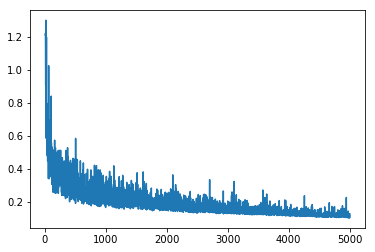

In [15]:
plt.plot(plot_loss['step'][10:], plot_loss['loss'][10:])

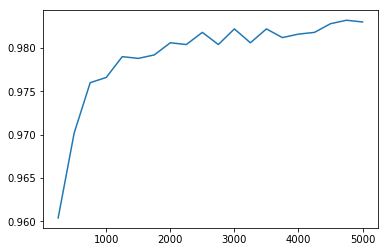

In [11]:
plt.plot(plot_accuracy['step'], plot_accuracy['accuracy'])

In [13]:
plot_loss['step'][1]

2

# Part2. Evaluate mnist data

In [ ]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import mnist_inference
EVAL_INTERVAL_SECS = 5

In [ ]:
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 30000
MOVING_AVERAGE_DECAY = 0.99

MODEL_SAVE_PATH = './model_save_dir/'

In [ ]:
def evaluate(mnist):
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
        y = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
        y_ = mnist_inference.inference(x)

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        ckpts = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
        for ckpt in ckpts.all_model_checkpoint_paths:
            with tf.Session() as sess:
                saver.restore(sess, ckpt)
                global_step = ckpt.split('/')[-1].split('-')[-1]
                validate_feed = {x:mnist.validation.images,
                                 y:mnist.validation.labels}
                accuracy_score = sess.run(accuracy, feed_dict=validate_feed)
                print('step %s: validation accuracy is %g.' % (global_step, accuracy_score))
            
            time.sleep(EVAL_INTERVAL_SECS)

In [ ]:
mnist = input_data.read_data_sets('./mnist_data/', one_hot=True)
evaluate(mnist)